In [1]:
import json
import generate_figures as gf

batch_file = '../data/json/cedar_batch_total_dedicated_nt_4d_2.json'
pilots8_file = '../data/json/cedar_pilots8_total_dedicated_nt_4d_2.json'
pilots16_file = '../data/json/cedar_pilots16_total_dedicated_nt_4d_2.json'

gf.batch = gf.load_json(batch_file)
gf.pilots8 = gf.load_json(pilots8_file)
gf.pilots16 = gf.load_json(pilots16_file)

In [2]:
#get makespans
assert(len(gf.batch)==len(gf.pilots8)==len(gf.pilots16))

dedicated_1 = gf.makespan_dict()
dedicated_2 = gf.makespan_dict()
dedicated_3 = gf.makespan_dict()
dedicated_4 = gf.makespan_dict()

gf.fill_dictionaries()
        

## FIGURE 0 - RAW

16


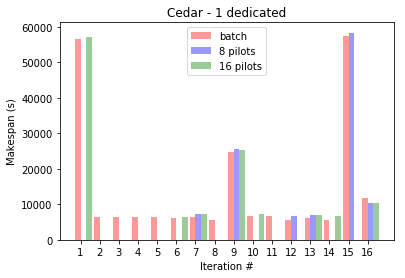

(45,
 {'name': '16n1d',
  'timestamp': '2019-05-04T09:28:16.341637',
  'start_time': 1556987296.34166,
  'end_time': 1556988700.4527092,
  'success': False,
  'worker_count': 16,
  'sid': [{'id': 20504392,
    'start_time': 1556988486.0144215,
    'end_time': 1556988693.9095714,
    'nodes': {'172.16.138.156': ['36864']},
    'succeeded': False},
   {'id': 20504396,
    'start_time': 1556988486.102522,
    'end_time': 1556988694.0275388,
    'nodes': {'172.16.138.156': ['39691']},
    'succeeded': False},
   {'id': 20504397,
    'start_time': 1556988486.0818074,
    'end_time': 1556988693.9466941,
    'nodes': {'172.16.138.156': ['37107']},
    'succeeded': False},
   {'id': 20504398,
    'start_time': 1556988486.2640657,
    'end_time': 1556988689.2976947,
    'nodes': {'172.16.138.156': ['45482']},
    'succeeded': False},
   {'id': 20504399,
    'start_time': 1556988486.1580346,
    'end_time': 1556988694.0666585,
    'nodes': {'172.16.138.156': ['38479']},
    'succeeded': False},


In [3]:
## 1 dedicated
gf.iteration_fig(gf.dedicated_1, 1, system="Cedar")
[el for el in [(i, el) for i,el in enumerate(gf.pilots16)] if '16n1d' in el[1]['name']][10]

17


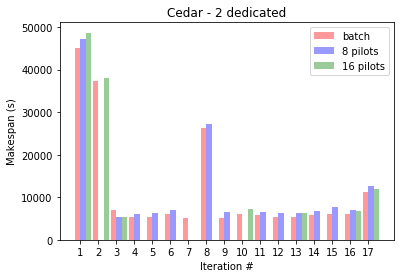

In [4]:
## 2 dedicated
gf.iteration_fig(gf.dedicated_2, 2, system="Cedar")

17


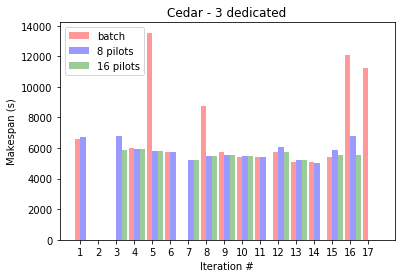

In [5]:
## 3 dedicated
gf.iteration_fig(gf.dedicated_3, 3, system="Cedar")

16


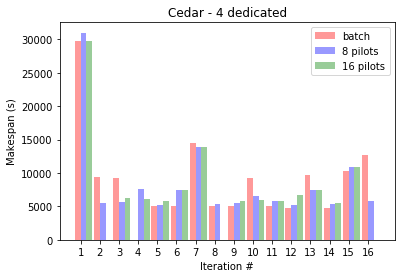

In [6]:
## 4 dedicated
gf.iteration_fig(gf.dedicated_4, 4, system="Cedar")

## FIGURE 1 - Makespan difference

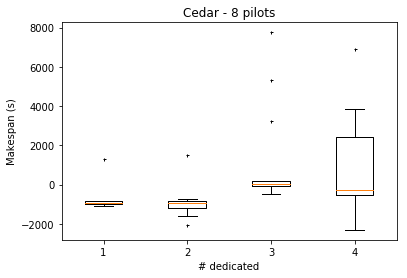

In [7]:
gf.makespan_box(gf.dedicated_1, gf.dedicated_2,
                gf.dedicated_3, gf.dedicated_4, 8, system="Cedar")

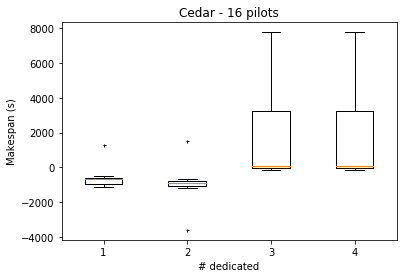

In [8]:
gf.makespan_box(gf.dedicated_1, gf.dedicated_2,
                gf.dedicated_3, gf.dedicated_3, 16, system="Cedar")

## Figure 2 - Queuing time difference

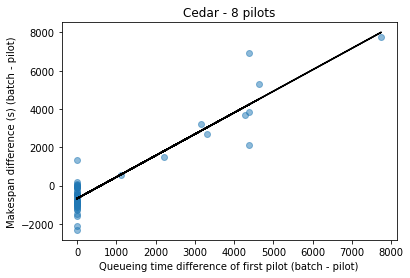

In [9]:
# Beluga 8 pilots
qxlabel = "Queueing time difference of first pilot (batch - pilot)"
qylabel = "Makespan difference (s) (batch - pilot)"

gf.scatter_fig(*gf.makespan_queue(8), num_pilots=8,
               xlabel=qxlabel, ylabel=qylabel, system="Cedar")


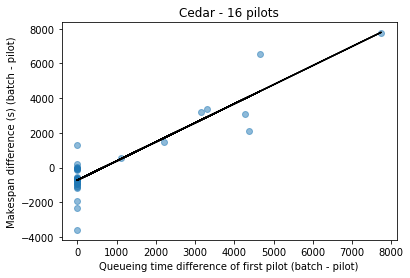

In [10]:
#Beluga 16 pilots
gf.scatter_fig(*gf.makespan_queue(16), num_pilots=16,
               xlabel=qxlabel, ylabel=qylabel, system="Cedar")

## Figure 3A - Average number of nodes

In [11]:
avgn_8pilots = [gf.get_pilot_avgnodes(job, gf.batch[idx])
                for idx, job in enumerate(gf.pilots8)
                if job['success']
                and job['end_time'] is not None
                and gf.batch[idx]['success']
                and gf.batch[idx]['end_time'] is not None]
avgn_16pilots = [gf.get_pilot_avgnodes(job, gf.batch[idx])
                 for idx, job in enumerate(gf.pilots16)
                 if job['success']
                 and job['end_time'] is not None
                 and gf.batch[idx]['success']
                 and gf.batch[idx]['end_time'] is not None]
avgn_batch = [gf.get_batch_avgnodes(job)
              for job in gf.batch 
              if job['success'] and job['end_time'] is not None]

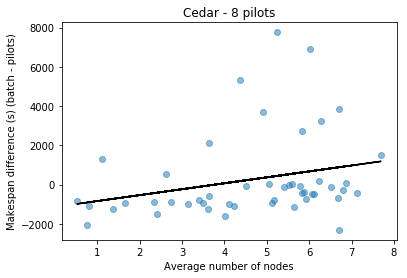

In [12]:
# 8 pilots
as_xlbl = "Average number of {}"
as_ylbl = "Makespan difference (s) (batch - pilots)"
gf.scatter_fig([i[0] for i in avgn_8pilots],
               [i[1] for i in avgn_8pilots], 8,
               xlabel=as_xlbl.format("nodes"),
               ylabel=as_ylbl, system="Cedar")

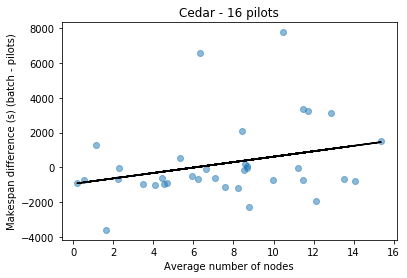

In [13]:
# 16 pilots
gf.scatter_fig([i[0] for i in avgn_16pilots],
               [i[1] for i in avgn_16pilots], 16,
               xlabel=as_xlbl.format("nodes"),
               ylabel=as_ylbl, system="Cedar")

## Figure 3B - Average number of pilots

In [14]:
avgp_8pilots = [gf.get_avgpilots(job, gf.batch[idx])
               for idx, job in enumerate(gf.pilots8)
               if job['success']
                and job['end_time'] is not None
                and gf.batch[idx]['success']]
avgp_16pilots = [gf.get_avgpilots(job, gf.batch[idx])
                for idx, job in enumerate(gf.pilots16)
                if job['success']
                 and job['end_time'] is not None
                 and gf.batch[idx]['success']]

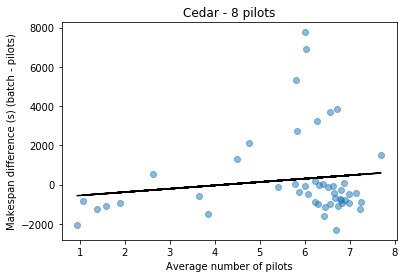

In [15]:
# 8 pilots
gf.scatter_fig([i[0] for i in avgp_8pilots],
               [i[1] for i in avgp_8pilots], 8,
               xlabel=as_xlbl.format("pilots"),
               ylabel=as_ylbl, system="Cedar")

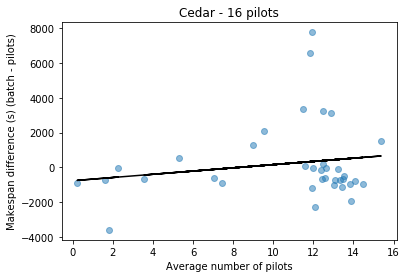

In [16]:
gf.scatter_fig([i[0] for i in avgp_16pilots],
               [i[1] for i in avgp_16pilots], 16,
               xlabel=as_xlbl.format("pilots"),
               ylabel=as_ylbl, system="Cedar")

In [17]:
batch_pilots8 = [el for el in list(zip(gf.batch, gf.pilots8))
                 if el[0]['success'] and el[1]['success']]

m1_m2_b8 = [(el[0]['end_time'] - el[0]['start_time'])
            / (el[1]['end_time'] - el[1]['start_time'])
            for el in batch_pilots8]

batch_aworkers = [(gf.get_batch_avgw(el[0])[0])
                     for el in batch_pilots8]
pilots8_aworkers = [(gf.get_pilot_avgw(el[1], el[0])[0])
                      for el in batch_pilots8]

w2_w1_b8 = [el[1] / el[0] for el in zip(batch_aworkers,
                                        pilots8_aworkers)]


In [18]:

batch_pilots16 = list(zip(gf.batch, gf.pilots16))
m1_m2_b16 = [(el[0]['end_time'] - el[0]['start_time'])
             / (el[1]['end_time'] - el[1]['start_time'])
            for el in batch_pilots16
             if el[0]['success'] and el[1]['success']]

w2_w1_b16 = [(gf.get_pilot_avgw(el[1], el[0])[0]
             / (gf.get_batch_avgw(el[0])[0]))
            for el in batch_pilots16
            if el[0]['success'] and el[1]['success']]

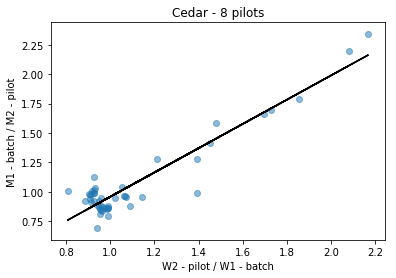

In [19]:
# 8 pilots
bm_x_lbl= "W2 - pilot / W1 - batch"
bm_y_lbl= "M1 - batch / M2 - pilot"
gf.scatter_fig(w2_w1_b8, m1_m2_b8, 8, bm_x_lbl, bm_y_lbl,
               system="Cedar")

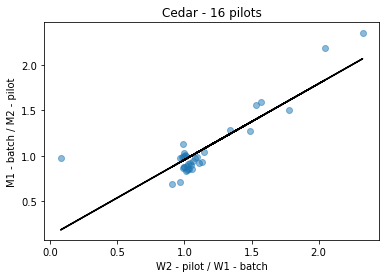

In [20]:
# 16 pilots
gf.scatter_fig(w2_w1_b16, m1_m2_b16, 16, bm_x_lbl, bm_y_lbl,
               system="Cedar")

In [21]:
import numpy as np
import matplotlib.lines as mlines
def basic_model(xy1, xy2, xy3, xy4, num_pilots, xlabel, ylabel, system="Beluga", save=None):   
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots()
    execution_mode = "Batch" if type(num_pilots) == str and "batch" in num_pilots else "Pilots" 
    ax.scatter(xy1[0], xy1[1], c="#6600cc", alpha=0.5, label="{} 1 dedicated".format(execution_mode))                                                  
    ax.scatter(xy2[0], xy2[1], c="#ff0000", alpha=0.5, label="{} 2 dedicated".format(execution_mode))
    ax.scatter(xy3[0], xy3[1], c="#ffa500", alpha=0.5, label="{} 3 dedicated".format(execution_mode))
    ax.scatter(xy4[0], xy4[1], c="#008000", alpha=0.5, label="{} 4 dedicated".format(execution_mode))
    
    if len(xy1) > 2:
        ax.scatter(xy1[2], xy1[3], c="#290066", marker="v", alpha=0.5, label="Pilots 1 dedicated")                                                  
        ax.scatter(xy2[2], xy2[3], c="#800033", marker="v", alpha=0.5, label="Pilots 2 dedicated")
        ax.scatter(xy3[2], xy3[3], c="#ff6600", marker="v", alpha=0.5, label="Pilots 3 dedicated")
        ax.scatter(xy4[2], xy4[3], c="#003300", marker="v", alpha=0.5, label="Pilots 4 dedicated")
        
    
    pilot_symbol = mlines.Line2D([], [], color="black", alpha=0.5, marker='v', linestyle='None',
                                 label='Pilots')
    batch_symbol = mlines.Line2D([], [], color="black", alpha=0.5, marker='o', linestyle='None',
                                 label='Batch')
    d1_symbol = mlines.Line2D([], [], color="purple", alpha=0.5, linestyle='-',
                              label='1 dedicated')
    d2_symbol = mlines.Line2D([], [], color="red", alpha=0.5, linestyle='-',
                              label='2 dedicated')
    d3_symbol = mlines.Line2D([], [], color="orange", alpha=0.5, linestyle='-',
                              label='3 dedicated')
    d4_symbol = mlines.Line2D([], [], color="green", alpha=0.5, linestyle='-',
                              label='4 dedicated')
    ax.legend(handles=[batch_symbol, pilot_symbol, d1_symbol,  d2_symbol, d3_symbol, d4_symbol])
    
    get_c = lambda x, y, z=False: (10*(x+20)*125)/y if z else 10*(x+20)*np.ceil(125/y)
    ceil_results = False
    n_workers = np.arange(5, 70)
    
    a = 0.2
    ax.plot(n_workers, get_c(45, n_workers, ceil_results),'-', c='purple', alpha=a)
    ax.plot(n_workers, get_c(90, n_workers, ceil_results), '-', c='red', alpha=a)
    ax.plot(n_workers, get_c(120, n_workers, ceil_results), '-', c='orange', alpha=a)
    ax.plot(n_workers, get_c(180, n_workers, ceil_results), '-', c='green', alpha=a)
    
    
    #b, m = np.polynomial.polynomial.polyfit(x, y, 1)                             
    #ax.plot(np.asarray(x), b + m*np.asarray(x), 'k-')                            
    ax.set_xlabel(xlabel)                                                        
    ax.set_ylabel(ylabel)                                                        
                                                                                 
    if save is None:                                                             
        ax.set_title('{0} - {1} pilots'.format(system, num_pilots))              
        plt.show()                                                               
    else:                                                                        
        plt.savefig(save)   

In [22]:
m_batch_1d = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']
             and "single" in el['name']]

w_batch_1d = [gf.get_batch_avgw(el)[0]
               for el in gf.batch if el['success']
               and "single" in el['name']]
m_batch_2d = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']
             and "double" in el['name']]

w_batch_2d = [gf.get_batch_avgw(el)[0]
               for el in gf.batch if el['success']
               and "double" in el['name']]

m_batch_3d = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']
             and "triple" in el['name'] and el['end_time'] is not None]

w_batch_3d = [gf.get_batch_avgw(el)[0]
               for el in gf.batch if el['success']
               and "triple" in el['name'] and el['end_time'] is not None]

m_batch_4d = [el['end_time'] - el['start_time']
              for el in gf.batch if el['success']
             and "quadruple" in el['name']]

w_batch_4d = [gf.get_batch_avgw(el)[0]
               for el in gf.batch if el['success']
               and "quadruple" in el['name']]

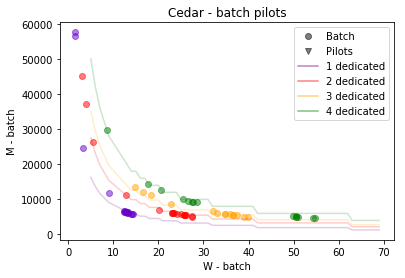

In [23]:
basic_model((w_batch_1d, m_batch_1d),
             (w_batch_2d, m_batch_2d),
             (w_batch_3d, m_batch_3d), (w_batch_4d, m_batch_4d),"batch",
               "W - batch", "M - batch",
               system="Cedar")

In [24]:
m_8p_1d = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']
          and '1d' in el['name']]

w_8p_1d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots8 if el['success']
           and '1d' in el['name']]

m_8p_2d = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']
          and '2d' in el['name']]

w_8p_2d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots8 if el['success']
           and '2d' in el['name']]
m_8p_3d = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']
          and '3d' in el['name']]

w_8p_3d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots8 if el['success']
           and '3d' in el['name']]

m_8p_4d = [(el['end_time'] - el['start_time'])
            for el in gf.pilots8 if el['success']
          and '4d' in el['name']]

w_8p_4d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots8 if el['success']
           and '4d' in el['name']]

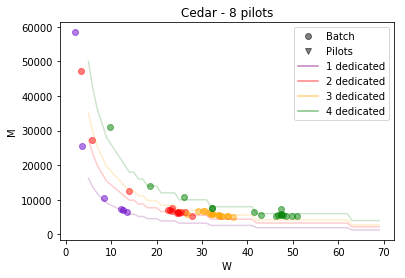

In [25]:
basic_model((w_8p_1d, m_8p_1d),
            (w_8p_2d, m_8p_2d),
            (w_8p_3d, m_8p_3d), (w_8p_4d, m_8p_4d), 8,
               "W", "M",
               system="Cedar")

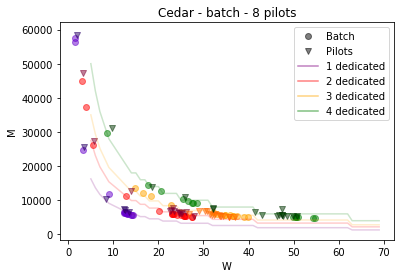

In [26]:
basic_model((w_batch_1d, m_batch_1d, w_8p_1d, m_8p_1d),
            (w_batch_2d, m_batch_2d, w_8p_2d, m_8p_2d),
            (w_batch_3d, m_batch_3d, w_8p_3d, m_8p_3d),
            (w_batch_4d, m_batch_4d, w_8p_4d, m_8p_4d), "batch - 8", "W", "M",
            system="Cedar")

In [27]:
m_16p_1d = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']
           and '1d' in el['name']]
w_16p_1d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots16 if el['success']
           and '1d' in el['name']]
m_16p_2d = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']
           and '2d' in el['name']]
w_16p_2d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots16 if el['success']
           and '2d' in el['name']]
m_16p_3d = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']
           and '3d' in el['name']]
w_16p_3d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots16 if el['success']
           and '3d' in el['name']]
m_16p_4d = [(el['end_time'] - el['start_time'])
        for el in gf.pilots16 if el['success']
           and '4d' in el['name']]
w_16p_4d = [gf.get_pilot_avgw(el, el)[0]
            for el in gf.pilots16 if el['success']
           and '4d' in el['name']]


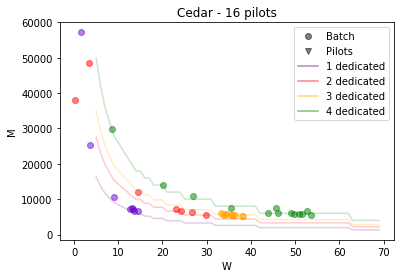

In [28]:
basic_model((w_16p_1d, m_16p_1d),
                (w_16p_2d, m_16p_2d),
                (w_16p_3d, m_16p_3d), (w_16p_4d, m_16p_4d), 16,
               "W", "M",
               system="Cedar")

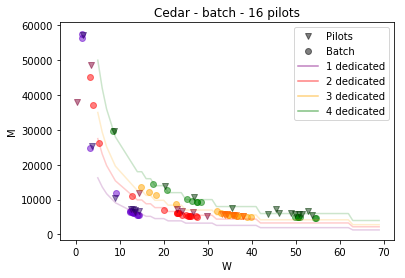

In [35]:
gf.basic_model((w_batch_1d, m_batch_1d, w_16p_1d, m_16p_1d),
            (w_batch_2d, m_batch_2d, w_16p_2d, m_16p_2d),
            (w_batch_3d, m_batch_3d, w_16p_3d, m_16p_3d),
            (w_batch_4d, m_batch_4d, w_16p_4d, m_16p_4d), "batch - 16", "W", "M",
            system="Cedar")

In [30]:
from statistics import mean
def pilot_queueing_times(submissions):
    result = [[p['start_time'] - s['start_time']
             if p['start_time'] is not None else -1
             for p in s['sid']]for s in submissions if s['success']]
    return [sorted(p) for p in result]

def avg_pilot_queueing(queue_times):
    result = {}
    
    for pilots in queue_times:
        for i in range(len(pilots)):
            if i in result:
                result[i].append(pilots[i])
            else:
                result[i] = [pilots[i]]
    return [mean(v) for k,v in sorted(result.items(), key=lambda x: x[0])]
    
res = pilot_queueing_times(gf.pilots16)



In [33]:
[((len(set(['{0}:{1}'.format(k, p)                     
    for k,v in x['sid'][0]['nodes'].items()    
    for p in v])) * (x['sid'][0]['end_time'] - x['sid'][0]['start_time']))
 / (x['end_time'] - x['start_time']), x['end_time'] - x['start_time'])
 for x in gf.batch if x['name'] == 'batch_triple' and x['success']
 and x['end_time'] is not None]

[(32.069507948894866, 6609.492099523544),
 (33.111207033523236, 6016.411475658417),
 (14.754800255766932, 13545.342313289642),
 (34.79103146471814, 5722.294448137283),
 (22.813245791414907, 8724.637403011322),
 (35.96327250191448, 5715.150685071945),
 (36.57450447306543, 5419.953354597092),
 (37.48293432711033, 5424.133612155914),
 (34.67582519410752, 5717.407341003418),
 (38.88759975227172, 5117.839675188065),
 (39.93178210502755, 5115.108418464661),
 (36.6355418026012, 5416.995577096939),
 (16.550834060058815, 12109.352428674698),
 (18.340405413565943, 11247.421619653702)]

In [34]:
1557243012.931211 - 1557242923.4021077

89.52910327911377